In [125]:
# imports
#bigqueryhelper
from google.cloud import bigquery
import pandas as pd
import numpy as np
import plotly
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [ ]:
# API key verification for Google Cloud
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="/Users/davidhofhuizen/Downloads/ambient-fuze-343609-fc7da1815720.json"
client = bigquery.Client()

Functions

In [126]:
def run_query(query):
    query_job = client.query(query)

    iterator = query_job.result(timeout=120)
    rows = list(iterator)

    # Transform the rows into a nice pandas dataframe
    result = pd.DataFrame(data=[list(x.values()) for x in rows], columns=list(rows[0].keys()))
    
    return result

In [158]:

def estimate_gigabytes_scanned(query, bq_client):
    """A useful function to estimate query size. 
    Originally from here: https://www.kaggle.com/sohier/beyond-queries-exploring-the-bigquery-api/
    """
    # We initiate a `QueryJobConfig` object
    # API description: https://googleapis.dev/py/bigquery/latest/generated/google.cloud.bigquery.job.QueryJobConfig.html
    my_job_config = bigquery.job.QueryJobConfig()
    
    # We turn on 'dry run', by setting the `QueryJobConfig` object's `dry_run` attribute.
    # This means that we do not actually run the query, but estimate its running cost. 
    my_job_config.dry_run = True

    # We activate the job_config by passing the `QueryJobConfig` to the client's `query` method.
    my_job = bq_client.query(query, job_config=my_job_config)
    
    # The results comes as bytes which we convert into Gigabytes for better readability
    BYTES_PER_GB = 2**30
    estimate = my_job.total_bytes_processed / BYTES_PER_GB
    
    print(f"This query will process {estimate} GBs.")

def balance_transform(value):
    return value / 100000000

Task at hand
- From 2009 to 2015, get all top 100 balannces from these years.
- The balances of these users will be used for time series analysis of transactions over time

In [128]:
def extract_data(year):
    year = int(year + 1)
    previous_year = year - 1
    
    # Query
    wealth_development = f"""
    WITH double_entry_book AS (
    -- debits
    SELECT array_to_string(inputs.addresses, ",") as address, inputs.type, -inputs.value as value, DATE(block_timestamp) as date
    FROM `bigquery-public-data.crypto_bitcoin.inputs` as inputs
    UNION ALL
    -- credits
    SELECT array_to_string(outputs.addresses, ",") as address, outputs.type, outputs.value as value, DATE(block_timestamp) as date
    FROM `bigquery-public-data.crypto_bitcoin.outputs` as outputs
    )
    SELECT address, type, sum(value) as balance, date, EXTRACT(YEAR FROM date) as year
    FROM double_entry_book
    WHERE date < '{year}-01-01'
    GROUP BY date, address, type
    ORDER BY balance DESC
    """

    # Extract data
    df = run_query(wealth_development)
    
    return df



In [129]:
def extract_data2(year):
    year = int(year + 1)
    
    # Query
    wealth_development = f'''
    WITH double_entry_book AS (
   -- debits
   SELECT array_to_string(inputs.addresses, ",") as address, inputs.type, -inputs.value as value, DATE(block_timestamp) as date
   FROM `bigquery-public-data.crypto_bitcoin.inputs` as inputs
   WHERE DATE(block_timestamp) < '{year}-01-01'
   UNION ALL
   -- credits
   SELECT array_to_string(outputs.addresses, ",") as address, outputs.type, outputs.value as value, DATE(block_timestamp) as date
   FROM `bigquery-public-data.crypto_bitcoin.outputs` as outputs
   WHERE DATE(block_timestamp) < '{year}-01-01'
    )
    SELECT address, type, sum(value) as balance
    FROM double_entry_book
    GROUP BY address, type
    ORDER BY balance DESC
    LIMIT 100
    '''

    # Extract data
    df = run_query(wealth_development)
    
    return df



In [130]:
def preprocess(original_df, year):
    df = original_df.copy()

    # make sure all balance changes occur in given year
    df = df[df['year'] == year]
    

    #Group by balance
    df['balance'] = df['balance'].astype('float')
    df = df.groupby(['address', 'type', 'year']).sum('balance').sort_values(by ='balance', ascending = False).head(100).reset_index()


    return df

In [133]:
def Main():

    years = list(range(2009,2016))
    
    for year in years:
        df = extract_data2(year)
        #df = preprocess(df, year)

        df.to_csv(f'Top100_{year}_2.csv')
        print(f'Year {year} done')

    
    return True

In [134]:
Main()

Year 2009 done
Year 2010 done
Year 2011 done
Year 2012 done
Year 2013 done
Year 2014 done
Year 2015 done


True

In [146]:
def get_addresses(years):
    #address_list = pd.DataFrame(columns = ['address'])
    address_list = []

    for year in years:
        

        df = pd.read_csv(f'Top100_{year}_2.csv')
        addresses = list(df['address'])

        address_list.extend(addresses)

    address_list = list(set(address_list))

    return address_list
        


In [151]:
early_adopters = tuple(get_addresses(list(range(2009,2016))))

In [253]:
len(early_adopters)

467

In [197]:
with open('early_adopters.txt', 'w') as filehandle:
    for listitem in early_adopters:
        filehandle.write('%s\n' % listitem)

In [163]:
adopters2009 = tuple(get_addresses([2009]))

In [170]:
def get_transactions(adopters):
    wealth_development = f"""
    WITH double_entry_book AS (
   -- debits
   SELECT array_to_string(inputs.addresses, ",") as address, inputs.type, -inputs.value as value, DATE(block_timestamp) as date
   FROM `bigquery-public-data.crypto_bitcoin.inputs` as inputs
   UNION ALL
   -- credits
   SELECT array_to_string(outputs.addresses, ",") as address, outputs.type, outputs.value as value, DATE(block_timestamp) as date
   FROM `bigquery-public-data.crypto_bitcoin.outputs` as outputs
    )
    SELECT address, type, sum(value) as balance, date, EXTRACT(YEAR FROM date) as year
    FROM double_entry_book
    where address IN {adopters}
    GROUP BY date, address, type
    ORDER BY balance DESC
    """

    df = run_query(wealth_development)

    return df


In [210]:
def get_balance_per_adopter(df):
    balance_per_adopter = df.groupby('address').sum().drop('year', axis =1).reset_index().sort_values(by = 'balance', ascending = False)

    return balance_per_adopter


In [254]:
def adopters_per_year(years):
    df_list = []

    for year in years:
    
        df = pd.read_csv(f'Top100_{year}_2.csv')
        addresses = tuple(df['address'])

        transactions = get_transactions(addresses)

        transactions['year'] = year
        df_list.append(transactions)

    return pd.concat(df_list, ignore_index=True).sort_values(by='date')
        

In [283]:
adopters_grouped = adopters_per_year(list(range(2009,2016)))

In [284]:
adopters_grouped.to_csv('early_adopters_by_year.csv')

In [295]:
adopters_grouped = pd.read_csv('early_adopters_by_year.csv')

In [250]:
# Draw Plot
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Balance', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.ticklabel_format(useOffset=False, style='plain')
    plt.plot(df[x], df[y], color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

In [198]:
early_adopter_transactions = get_transactions(early_adopters)

In [294]:
def transaction_processing(df_old):
    df = df_old.copy()

    df['balance'] = df['balance'].astype('int')
    df['date'] = pd.to_datetime(df['date'])
    df['balance'] = df['balance'].apply(balance_transform)
    
    return df

In [206]:
early_adopter_transactions_processed = transaction_processing(early_adopter_transactions)

In [252]:
early_adopter_transactions.to_csv('All_transactions_early_adopters.csv')

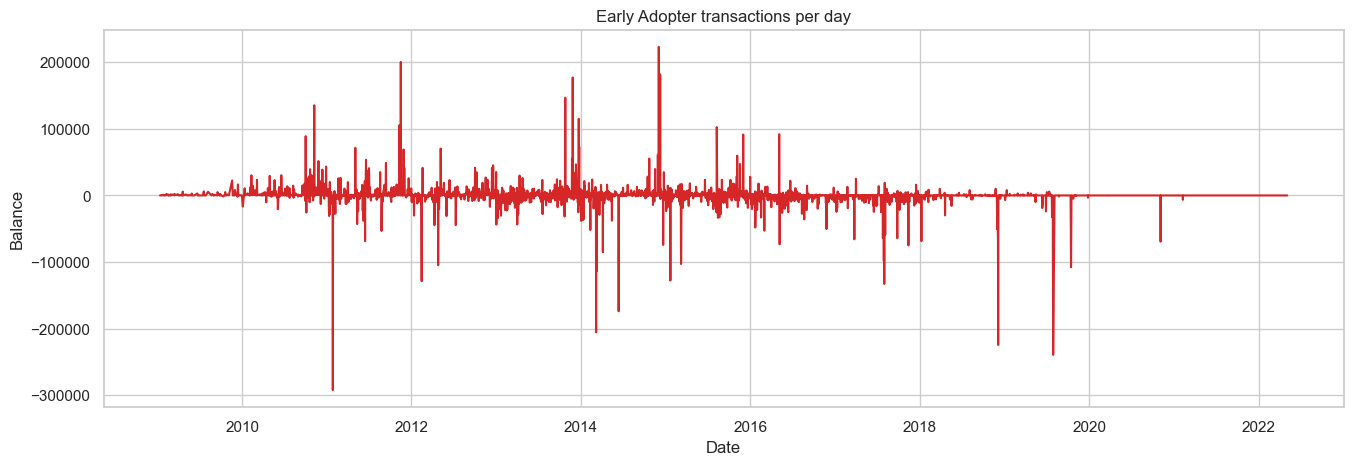

In [227]:
transactions_over_time = early_adopter_transactions_processed[['date', 'balance']].groupby('date').sum().reset_index()
plot_df(transactions_over_time, 'date', 'balance', title="Early Adopter transactions per day", xlabel='Date', ylabel='Balance', dpi=100)

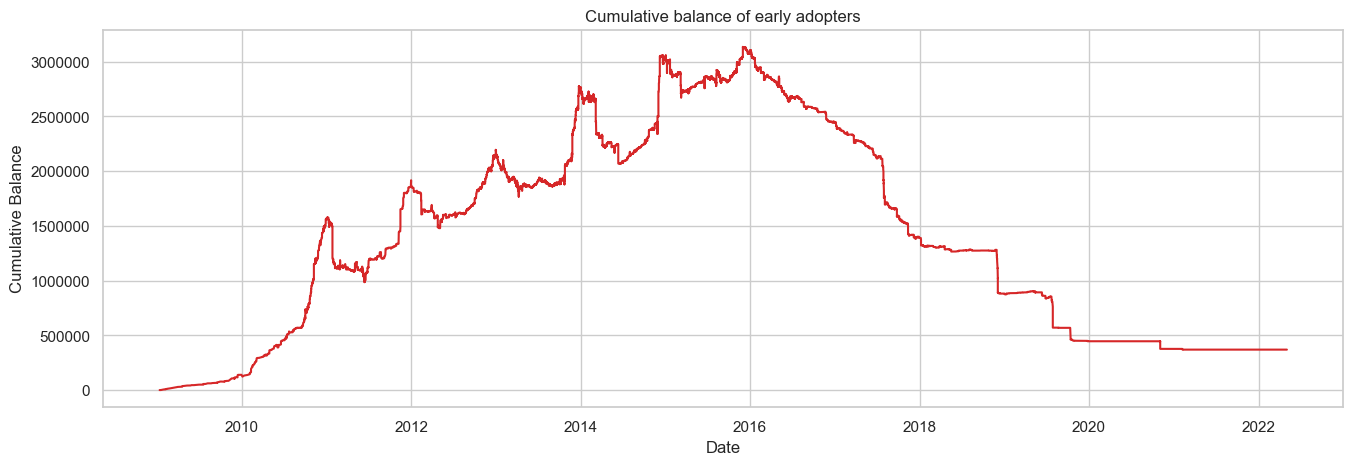

In [251]:
cumulative_balance_over_time = early_adopter_transactions_processed.copy()[['date', 'balance']].sort_values(by= 'date')
cumulative_balance_over_time['cumulative_balance'] = cumulative_balance_over_time['balance'].cumsum()

plot_df(cumulative_balance_over_time, 'date', 'cumulative_balance', title="Cumulative balance of early adopters", xlabel='Date', ylabel='Cumulative Balance', dpi=100)

In [292]:
def plot_grouped_adopters(df):
    # key gives the group name (i.e. category), data gives the actual values
    fig, ax = plt.subplots(figsize=(16,5))
    plt.ticklabel_format(useOffset=False, style='plain')

    for key, data in df.groupby('year'):
        data.plot(x='date', y='balance', ax=ax, label=key)

    return True

True

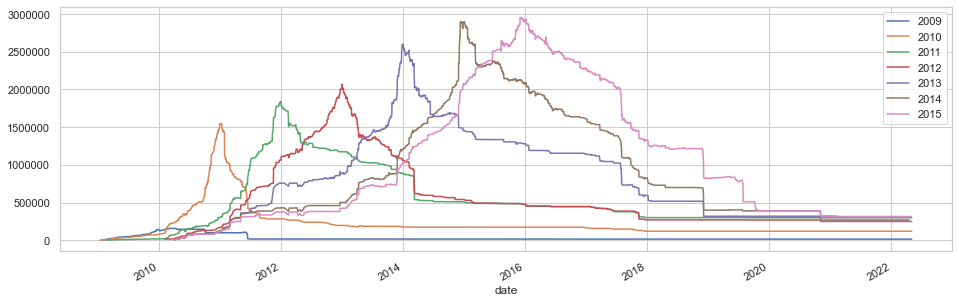

In [296]:
plot_grouped_adopters(transaction_processing(adopters_grouped).groupby(['year', 'date']).sum().groupby(level=0).cumsum().reset_index())

In [297]:
adopters_grouped.describe()

,Unnamed: 0,balance,year
count,33080.000,33080.000,33080.000
mean,16539.500,4770285047.771,2013.090
std,9549.518,585403861562.273,1.604
min,0.000,-14434153604935.000,2009.000
25%,8269.750,643.000,2012.000
50%,16539.500,14353.000,2013.000
75%,24809.250,15000000000.000,2014.000
max,33079.000,21751763438199.000,2015.000


In [282]:
adopters_grouped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33080 entries, 0 to 33079
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   address  33080 non-null  object        
 1   type     33080 non-null  object        
 2   balance  33080 non-null  float64       
 3   date     33080 non-null  datetime64[ns]
 4   year     33080 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 1.3+ MB


In [208]:
balance_per_adopter = get_balance_per_adopter(early_adopter_transactions_processed)

In [209]:
balance_per_adopter.head()

,address,balance
262,1FeexV6bAHb8ybZjqQMjJrcCrHGW9sb6uF,79957.218
355,1LdRcdxfbSnmCYYNdeYpUnztiYzVfBEQeC,53880.062
13,12ib7dApVFvg82TXKycWBNpN8kFyiAN1dr,31000.070
18,12tkqA9xSoowkzoERHMWNKsTey55YEBqkv,28151.059
417,1PeizMg76Cf96nUQrYg8xuoZWLQozU5zGW,19414.431
